## Jupyter notebook for modeling and prediction.

Import libraries that I will use.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')#Sentence tokenizer
import pickle
from sklearn.model_selection import train_test_split
import zipfile



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joaquin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load the data

In [6]:
# unzip the data

with zipfile.ZipFile('./train_y.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

with zipfile.ZipFile('./train_x.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

with zipfile.ZipFile('./y_test.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

with zipfile.ZipFile('./test.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [7]:

#Import data y trained.
# Open the file in binary mode
with open('train_y.pkl', 'rb') as file:
      
    # Call load method to deserialze
    train_y = pickle.load(file)
  

#Import data x trained.
with open('train_x.pkl', 'rb') as file:
      
    # Call load method to deserialze
    train_x = pickle.load(file)


#Import data y to test.
with open('y_test.pkl', 'rb') as file:
      
    # Call load method to deserialze
    y_test = pickle.load(file)
    

#Import data x to test
with open('test.pkl', 'rb') as file:
      
    # Call load method to deserialze
    test = pickle.load(file)



## Prediction with Gaussian NB

Now we have a training set, so we can train a model. Lets start with a Gaussian NB. For run GaussianNB uncomment the following cells. 

In [8]:
from sklearn.naive_bayes import GaussianNB

#Initialize GaussianNB classifier
model = GaussianNB()
#Fit the model on the train dataset
model = model.fit(train_x, train_y)
#Make predictions on the test dataset
pred = model.predict(test)

Lets see the accuracy of the model.

In [9]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(y_test, pred)*100, "%")

Accuracy: 53.196147110332745 %


We can see that its not much different as take random choices. Maby with a gridsearch we can find better hyperparameters to get a model that perform better.

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 
gs_NB.fit(train_x, train_y)

gs_NB.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'var_smoothing': 0.1}

In [12]:
pred = gs_NB.best_estimator_.predict(test)

In [13]:
print("Accuracy:", accuracy_score(y_test, pred)*100, "%")

Accuracy: 55.166374781085814 %


The accuracy raice a 2%, but still low. Let's try with other model, but first we will predict the test data for kaggel competition.

In [14]:
dir_data_test = './test.csv'
df_test = pd.read_csv(dir_data_test)
pd.set_option('max_colwidth', 1000)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
df_test.keyword = df_test.keyword.apply(lambda x: str(x))

In [16]:
df_test.keyword = df_test.keyword.apply(lambda x: 'no_keyword' if x=='nan' else x)

<BarContainer object of 2 artists>

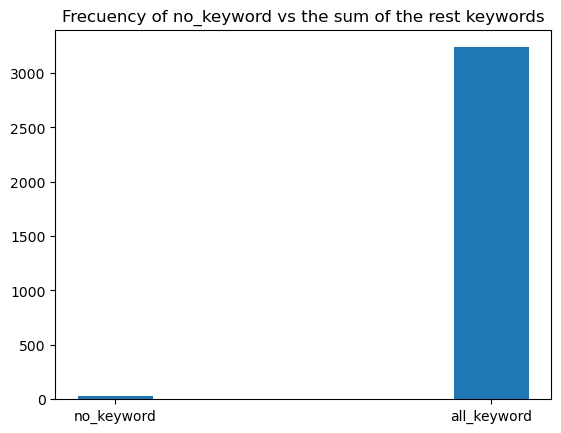

In [17]:
key_freq = df_test['keyword'].value_counts()
keyword_dic = {}
keyword_dic['no_keyword'] = key_freq['no_keyword']
keyword_dic['all_keyword'] = sum(key_freq[key_freq.keys()!='no_keyword'])
x = keyword_dic.keys()
heigh = keyword_dic.values()
plt.title('Frecuency of no_keyword vs the sum of the rest keywords')
plt.bar(x, heigh, width=0.2,align= 'center')

Same distribution that train test, so we add the keyword at the end of the twitt.

In [18]:
#Clean text from noise
def clean_text(text):
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
       
    return text

In [19]:
df_test['clean_text'] = df_test.text.apply(lambda x: clean_text(x))

In [20]:
df_test['clean_text'] = df_test['clean_text'] + ' ' + df_test['keyword']

In [21]:
df_test.clean_text

0                                                                                                                just happened a terrible car crash no_keyword
1                                                                                  heard about  earthquake is different cities  stay safe everyone  no_keyword
2                                                  there is a forest fire at spot pond  geese are fleeing across the street  i cannot save them all no_keyword
3                                                                                                          apocalypse lighting   spokane  wildfires no_keyword
4                                                                                                     typhoon soudelor kills    in china and taiwan no_keyword
                                                                                 ...                                                                          
3258                                          

Now we create de list "prediction" for apply the model to de test dataset.

In [22]:
#Import data x to test
with open('bag_of_words.pkl', 'rb') as file:
      
    # Call load method to deserialze
    bag_of_words = pickle.load(file)

In [23]:
lemm = WordNetLemmatizer() # Inicialice lemmatizer. 
prediction =[]
for i,twitt in enumerate(df_test.clean_text):
    bag = []
    pattern_words = [lemm.lemmatize(word.lower()) for word in twitt]
    # create bag of words array,if word match found in current pattern then put 1 otherwise 0.[row * colm(263)]
    for w in bag_of_words:
        if w in pattern_words:
            bag.append(1)
        else:
            bag.append(0)
    prediction.append(bag)

Now let's predict!

In [24]:
pred_test = gs_NB.best_estimator_.predict(prediction)

In [25]:
prediction_test = pred_test.tolist()

In [26]:
dict_prediction = {}
dict_prediction['id'] = df_test.id
dict_prediction['target'] = prediction_test


In [27]:
df_prediction = pd.DataFrame(dict_prediction)

In [28]:
df_prediction[:20] # First 20 predictions

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [29]:
df_prediction.to_csv('./prediction_gaussiannb_gridCV.csv',index=False)

For some reason all prediction are zero :(

## Predict with Neural Network

We make a DNN with a first layer of 1024 neurons and activation 'relu'. We set a dropuot of 30% and a batch normalization. In total there are 3 layers. 

In [30]:
from tensorflow import keras
from tensorflow.keras import layers

In [31]:
input_shape = [len(train_x[0])]

In [32]:

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),    
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [34]:
train_x = np.array(train_x)
train_y = np.array(train_y)
test = np.array(test)
y_test = np.array(y_test)

Try without earlystop

In [35]:
from tensorflow.keras import layers, callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [36]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    train_x, train_y,
    validation_data = (test,y_test),
    batch_size=32,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.6561
Best Validation Accuracy: 0.5954


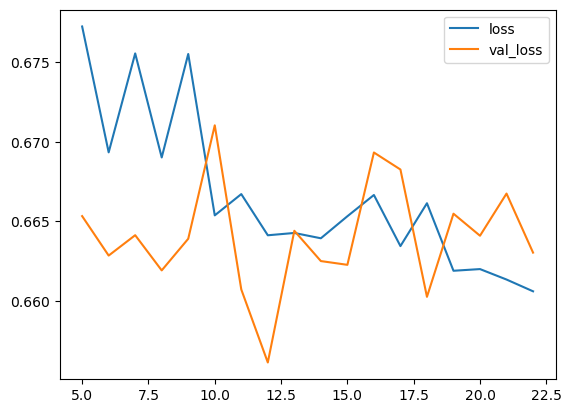

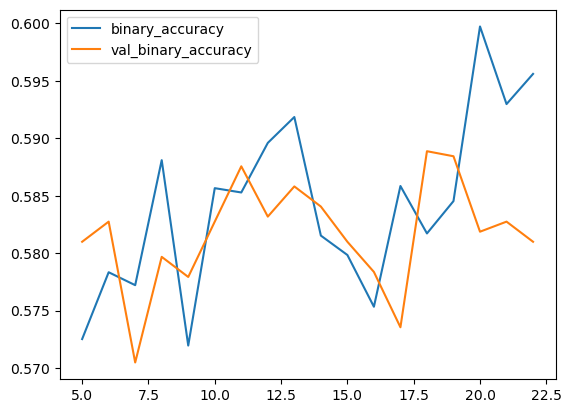

In [37]:


history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))



In [38]:
# testing =[]
# for i,twitt in enumerate(df_test.text):
#     pattern_words = [lemm.lemmatize(word.lower()) for word in twitt]
#     # create bag of words array,if word match found in current pattern then put 1 otherwise 0.[row * colm(263)]
#     for w in bag_of_words:
#         bag.append(1) if w in pattern_words else bag.append(0)
#     testing.append(bag)
# testing = np.array(testing)
   

In [40]:
pred_test_nn = model.predict(np.array(prediction))

102/102 [==============================] - 2s 15ms/step


In [43]:
round(pred_test_nn)

TypeError: type numpy.ndarray doesn't define __round__ method

In [45]:
pred_round = [np.round(x) for x in pred_test_nn]

In [51]:
pred_round = [x.tolist() for x in pred_test]

In [53]:
len(pred_round)

3263

In [54]:
dict_prediction = {}
dict_prediction['id'] = df_test.id
dict_prediction['target'] = pred_round
df_prediction = pd.DataFrame(dict_prediction)
df_prediction.to_csv('./prediction_NN.csv',index=False)